In [1]:
import mouseQPCRModelSelection 
import numpy as np
import time
import AssignGPGibbsSingleLoop
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
GPflow.__version__

'0.1.3'

In [3]:
Bpossible = np.linspace(2,70,3)
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=0)
Y = Yall[:,0][None].T
print 'Y'
print Y.shape
strExp = 'MouseQPCR_Exp1'
m,mV = mouseQPCRModelSelection.InitModels(pt,Y,nsparse=100)

Loaded GPLVM data/guo_ssData.p with nrowsXncols = (437, 2).
LoadMouseQPCRData output
Y
(437, 1)
Branching kernel =====================
unnamed.branchkernelparam.kern.variance transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.lengthscales transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.Bv transform:(none) prior:None
[[ 1.]]
unnamed.white.variance transform:+ve prior:None
[ 1.]
Created 100 inducing points in [0.0,91.7]
Initialise models: MAP =====================
model.likelihood.variance transform:+ve prior:None
[ 1.]

model.kern.branchkernelparam.kern.variance transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.lengthscales transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.Bv transform:(none) prior:None
[[ 1.]]
model.kern.white.variance transform:+ve prior:None [FIXED]
[  1.00000000e-06]
Initialise models: VB =====================
compiling tensorflow function...
done


In [4]:
# mV.make_tf_array(mV._free_vars)
# with mV.tf_mode():
#     f = mV.build_likelihood() 
# f

In [5]:
Bpossible=None
strSaveState='test'
fSoftVBAssignment=False
fOptimizeHyperparameters = False
fReestimateMAPZ=False
numMAPsteps = 10
D=Y.shape[1]
print D

1


In [6]:
# Do the MAP solution and plot assignments
t0 = time.time()

Kbranch = m.kern
pt = mV.t
b = 20

Bcrap = np.atleast_2d(b) # crappy branch point

# reinitialise hyperparameters
Kbranch.white.variance = 1e-6
Kbranch.branchkernelparam.kern.lengthscales = 100 # 20 + (90. - b) / 2. # 65
Kbranch.branchkernelparam.kern.variance = 2 #0.0012 #  2.3158
m.likelihood.variance = 0.08
mV.likelihood.variance = m.likelihood.variance._array

# should recompute Kernel everytime we update kernel hyperparameters
m.CompileAssignmentProbability(fDebug=False,fMAP=True) 

# set branching point
m.kern.branchkernelparam.Bv = Bcrap 

print '============> B=' + str(m.kern.branchkernelparam.Bv._array.flatten())

# Random assignment for given branch point

np.random.seed(47)

randomAssignment = AssignGPGibbsSingleLoop.GetRandomInit(pt,Bcrap,m.indices)
print 'MAP assignment.'
(chainState, bestAssignment,_,condProbs) = \
    m.InferenceGibbsMAP(fReturnAssignmentHistory=True,fDebug=False,\
    maximumNumberOfSteps=numMAPsteps,\
    startingAssignment=list(randomAssignment))
    

elapsedMAPTime = time.time() - t0
print 'MAP times %g secs'%elapsedMAPTime

# Very important!    
mV.kern.branchkernelparam.Bv.fixed = False
mV._compile()


============> B=[ 20.]
MAP assignment.
Performing MAP inference with B=[ 20.]
Converged after 2 iterations, lik=92731601.259
MAP times 39.0861 secs
compiling tensorflow function...
done


In [7]:
m

Name,values,prior,constriant
model.likelihood.variance,[ 0.08],None,+ve
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.branchkernelparam.Bv,[[ 20.]],None,(none)
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]


In [8]:
mV

Name,values,prior,constriant
model.likelihood.variance,[ 0.08],None,+ve
model.kern.branchkernelparam.kern.variance,[ 1.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 1.],None,+ve
model.kern.branchkernelparam.Bv,[[ 20.]],None,(none)
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.logPhi,"[[-0.02943348 1.16353402 0.18573085 ..., 0.1843601 0.23663663 -0.62717911] [ 0.16332079 0.84162124 0.20741308 ..., 0.95372134 -0.67037926 -1.44527122] [-2.21797768 0.13743332 -1.75992416 ..., -0.26272921 -0.58649328 1.77112498] ..., [-0.59431097 -0.41607347 -1.05930052 ..., 0.95344531 -1.77239847 -0.43940953] [-0.43263917 -0.67868303 -1.17136154 ..., 1.67926712 1.48264911 -0.06464603] [ 0.20540341 -0.09425731 0.51769218 ..., 1.12683881 0.3729014 -0.22228037]]",None,(none)


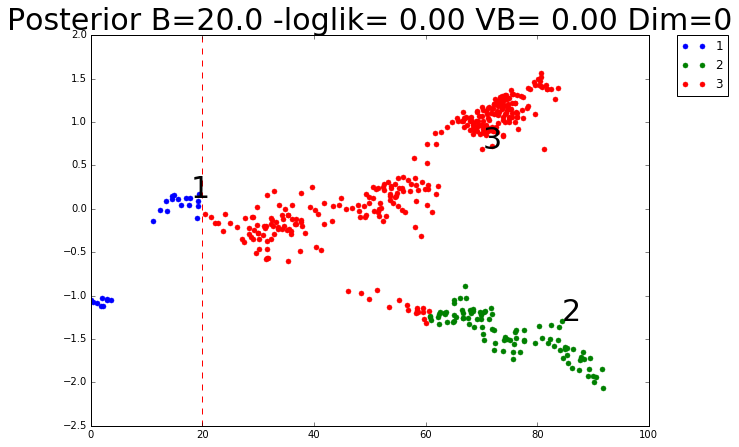

In [9]:
# Plot MAP solution
assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=None, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))

In [10]:
mV.compute_log_likelihood()

array([-5780.75366242])

In [11]:
mV.kern.branchkernelparam.Bv.fixed = True 
mV.optimize()

compiling tensorflow function...
done
optimization terminated, setting model state


      fun: array([ 462.8151076])
 hess_inv: <572910x572910 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.60452639e-03,  -0.00000000e+00,   0.00000000e+00, ...,
        -3.70692084e-22,   7.18187265e-09,  -7.18187243e-09])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 300
      nit: 218
   status: 0
  success: True
        x: array([  5.33699340e-01,  -8.49108733e+03,   2.05272934e+03, ...,
        -1.69596986e-01,   4.88105571e+01,   2.74330992e+01])

In [12]:
mV

Name,values,prior,constriant
model.likelihood.variance,[ 0.99518652],None,+ve
model.kern.branchkernelparam.kern.variance,[ 0.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ inf],None,+ve
model.kern.branchkernelparam.Bv,[[ 20.]],None,[FIXED]
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.logPhi,"[[ 40.57936803 0.27412512 2.56907615 ..., 2.57523353 2.60446087 1.43671169] [ 2.45602675 1.56038978 2.47550584 ..., 1.08039152 1.35973232 -0.07153937] [ -1.40189658 2.50232566 -0.64821515 ..., 2.04770552 1.50674214 -7.82817606] ..., [ 1.43923855 1.73784687 0.595821 ..., 1.07848889 -0.67625611 1.7058403 ] [ 1.73173467 1.29665413 0.37998765 ..., -6.00087069 -2.90504021 2.28786418] [ 2.35295978 2.14330332 2.20735385 ..., -0.16959699 48.81055712 27.43309919]]",None,(none)


plotting mv


InvalidArgumentError: Input is not invertible.
	 [[Node: f0f1/invKbb = MatrixInverse[T=DT_DOUBLE, adjoint=false, _device="/job:localhost/replica:0/task:0/cpu:0"](f0f1/add_4)]]
Caused by op u'f0f1/invKbb', defined at:
  File "/Users/mqbssaby/anaconda/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/mqbssaby/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3012, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-505c3b026466>", line 3, in <module>
    assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30,                       mV=mV, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))
  File "assigngp_dense.py", line 51, in PlotSample
    mu, var = mV.predict_f(Xtest)
  File "/Users/mqbssaby/pythonlibs/GPflow/GPflow/model.py", line 90, in runnable
    graph = tf_method(instance, *self.tf_args)
  File "/Users/mqbssaby/pythonlibs/GPflow/GPflow/model.py", line 392, in predict_f
    return self.build_predict(Xnew)
  File "assigngp_dense.py", line 267, in build_predict
    return self.build_predict_sparse(Xnew)
  File "assigngp_dense.py", line 311, in build_predict_sparse
    K = self.kern.K(self.X)
  File "/Users/mqbssaby/pythonlibs/GPflow/GPflow/kernels.py", line 336, in K
    return reduce(tf.add, [k.K(X, X2) for k in self.kern_list])
  File "branch_kernParamGPflow.py", line 158, in K
    Kbbs_inv = tf.matrix_inverse(kbb, name='invKbb') # B X B
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 301, in matrix_inverse
    name=name)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 683, in apply_op
    op_def=op_def)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2154, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/mqbssaby/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1154, in __init__
    self._traceback = _extract_stack()


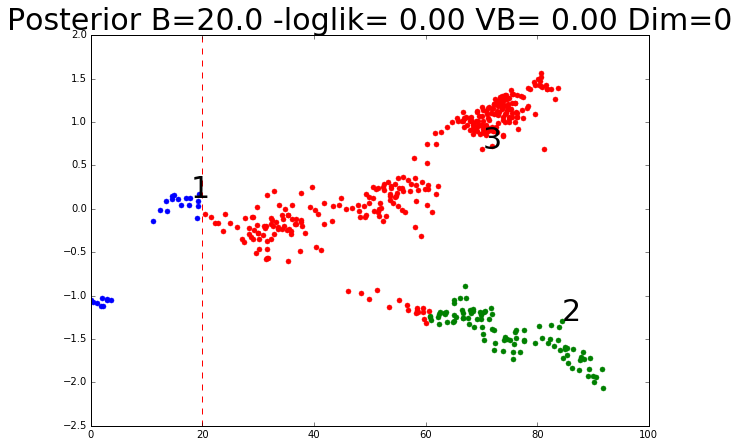

In [13]:
# Plot MAP solution 
# UNDONE need prediction for sparse VB
assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=mV, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))

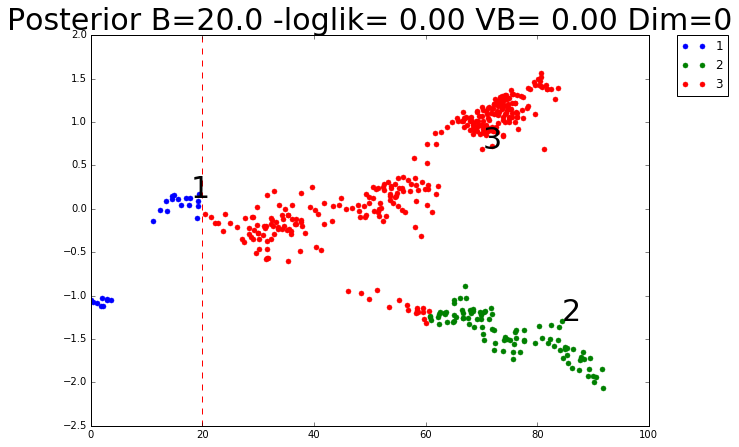

In [14]:
# Plot MAP solution 
# UNDONE need prediction for sparse VB
assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=None, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))